## Introduction

Suicide is a deeply sensitive and profoundly complex issue that touches the lives of many individuals and communities worldwide. According to the World Health Organization (WHO), nearly 800,000 people die due to suicide every year, which translates to one person every 40 seconds. It is the 10th leading cause of death globally. Those who relate to suicide often experience feelings of profound isolation and a pervasive sense of insignificance. This stark reality underscores the urgency to connect with those grappling with this formidable struggle.
In light of this, I have embarked on a mission to harness the power of Natural Language Processing (NLP) to develop an algorithm capable of scrutinizing tweets. Its purpose is to pinpoint potentially distressing posts, potentially indicative of suicidal thoughts. Through this endeavor, the aim is to identify these individuals and inspire a collective effort to extend a helping hand, letting them know that they are valued and worthy of a fulfilling life.


## Table of Contents
1. [Importing dependencies](#p1)
2. [Importing dataset](#p2)
3. [Preprocessing Text](#p3)
4. [Explatory Data Analysis](#p4)
5. [Preparing data](#p5)
6. [Vectorising data](#p6)
7. [Creating and Evaluating Model](#p7)
8. [Saving and Using the Models](#p8)
9. [Conclusion](#p9)


## <a name="p1">Importing Dependencies</a>

In [109]:
import pandas as pd 
import numpy as np 
import matplotlib.pyplot as plt 
import tensorflow as tf 
import seaborn as sns 
import re
try:
    import tweepy
except: 
    !pip install tweepy

## <a name="p2">Importing dataset</a>
The dataset being used is the **Suicidal Tweet Detection Dataset**. Check https://www.kaggle.com/datasets/aunanya875/suicidal-tweet-detection-dataset

In [4]:
data = pd.read_csv('./Suicide_Ideation_Dataset(Twitter-based).csv')
display(data.shape)
data.head()

(1787, 2)

,Tweet,Suicide
0,making some lunch,Not Suicide post
1,@Alexia You want his money.,Not Suicide post
2,@dizzyhrvy that crap took me forever to put to...,Potential Suicide post
3,@jnaylor #kiwitweets Hey Jer! Since when did y...,Not Suicide post
4,Trying out &quot;Delicious Library 2&quot; wit...,Not Suicide post


## <a name="p3">Preprocessing Text</a>


In [20]:
#drop null values
data = data.dropna()

In [21]:
# Defining dictionary containing all emojis with their meanings.
emojis = {':)': 'smile', ':-)': 'smile', ';d': 'wink', ':-E': 'vampire', ':(': 'sad', 
          ':-(': 'sad', ':-<': 'sad', ':P': 'raspberry', ':O': 'surprised',
          ':-@': 'shocked', ':@': 'shocked',':-$': 'confused', ':\\': 'annoyed', 
          ':#': 'mute', ':X': 'mute', ':^)': 'smile', ':-&': 'confused', '$_$': 'greedy',
          '@@': 'eyeroll', ':-!': 'confused', ':-D': 'smile', ':-0': 'yell', 'O.o': 'confused',
          '<(-_-)>': 'robot', 'd[-_-]b': 'dj', ":'-)": 'sadsmile', ';)': 'wink', 
          ';-)': 'wink', 'O:-)': 'angel','O*-)': 'angel','(:-D': 'gossip', '=^.^=': 'cat'}


In [22]:
import re
def preprocess(text):
    
    #lowercasing the tweets
    text=text.lower()
    
    #removing the username that the tweet is responding to
    userPattern = r'@\w+\s?'
    text = re.sub(userPattern, '', text)
    
    #Removing urls from tweets 
    urlPattern= r"((http://)[^ ]*|(https://)[^ ]*|( www\.)[^ ]*)"
    text= re.sub(urlPattern, 'URL', text)
    
    #Replacing Emojis
    for emoji in emojis.keys():
        text = text.replace(emoji, "EMOJI" + emojis[emoji]) 
    
    # Replace all non alphabets.
    alphaPattern      = "[^a-zA-Z0-9]"
    text = re.sub(alphaPattern, " ", text)
    
    return text 
data['Tweet']= data['Tweet'].apply(preprocess)
data['Tweet'].head()

0                                    making some lunch
1                                  you want his money 
2    that crap took me forever to put together  i  ...
3     kiwitweets hey jer  since when did you start ...
4    trying out  quotemojiwinkelicious library 2 qu...
Name: Tweet, dtype: object

In [25]:
label_encoder= {"Not Suicide post":0, "Potential Suicide post ":1}
data['Suicide']= data['Suicide'].apply(lambda x: label_encoder[x])

## <a name="p4">Explatory Data Analysis</a>


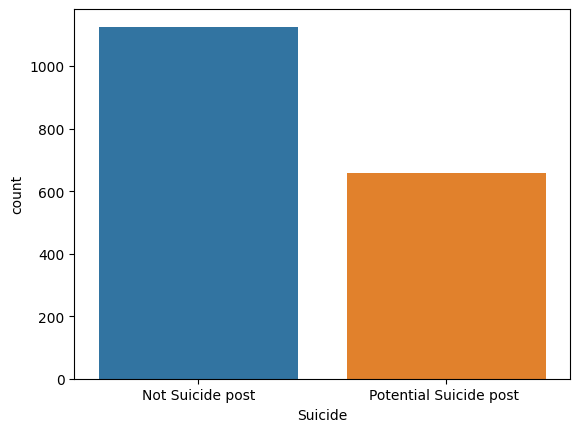

In [12]:
sns.countplot(data=data,x='Suicide')
plt.show()


The dataset is imbalanced, the not suicidal post are approximately double the potential suicide post. we may want to do some class weighting when updating the loss function afterwards.

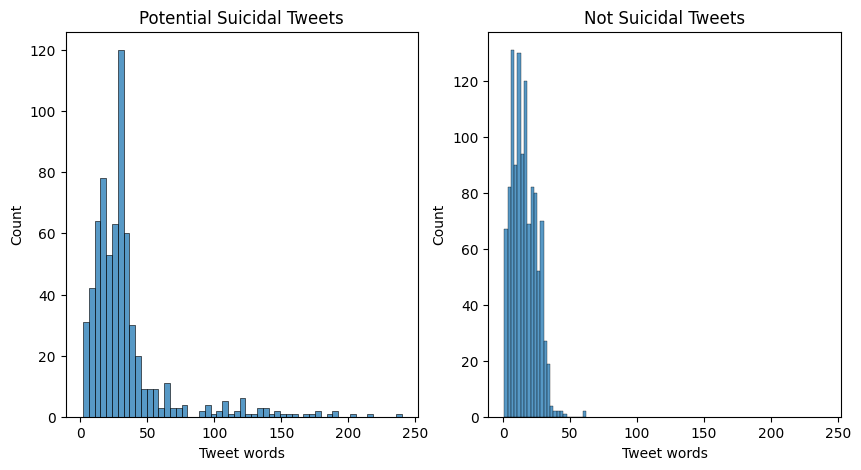

In [49]:
#Analysing the distribution of word counts of suicidal and not suicidal tweets
fig, axs= plt.subplots(1,2,sharex=True, figsize=(10,5))
suicide_tweets=data[data['Suicide']==1]
not_suicide_tweets=data[data['Suicide']==0]
sns.histplot(suicide_tweets['Tweet'].apply(lambda x:len(x.split(" "))),ax=axs[0]).set(xlabel='Tweet words',title='Potential Suicidal Tweets')
sns.histplot(not_suicide_tweets['Tweet'].apply(lambda x:len(x.split(" "))),ax=axs[1]).set(xlabel='Tweet words',title='Not Suicidal Tweets')
plt.show()


It seems that Potential Suicidal Tweets tend to be longer than not suicidal Tweets.

## <a name="p5">Preparing data</a>

To optimize our data for model training, I'll begin by transforming it into a TensorFlow dataset. This conversion allows us to harness the powerful capabilities TensorFlow offers for handling datasets, such as convenient batching, shuffling, and prefetching.

In [48]:
#fixing the seed for reproducibility
SEED=42
tf.random.set_seed(SEED)

In [51]:
#Creating a tensorflow dataset
tf_dataset= tf.data.Dataset.from_tensor_slices((data['Tweet'].values, data['Suicide'].values))

total_samples=len(tf_dataset)
# Define the sizes for training, validation, and test sets
train_size = int(0.7 * total_samples)  # 70% for training
val_size = int(0.15 * total_samples)   # 15% for validation
test_size = total_samples - train_size - val_size  # Remaining for test

In [52]:
train_set = tf_dataset.take(train_size).shuffle(5000, seed=42).batch(32).prefetch(1)
valid_set = tf_dataset.skip(train_size).take(val_size).batch(32).prefetch(1)
test_set = tf_dataset.skip(train_size+val_size).batch(32).prefetch(1)


## <a name="p6">Vectorising data</a>

In [53]:
vocab_size=1000
text_vec= tf.keras.layers.TextVectorization(max_tokens=vocab_size)
text_vec.adapt(train_set.map(lambda tweet,target: tweet))


## <a name="p7">Creating and Evaluating Model</a>

This model was built after a lot of testing and evaluation and hyperparameter tuning. It is slightly overfitting but I am satisfied with the best validation accuracy (93.26%) and the test accuracy (91.82%)

In [85]:
output_dim=10
learning_rate=0.001
model = tf.keras.Sequential([
    tf.keras.layers.Input(shape=[],dtype=tf.string),
    text_vec,
    tf.keras.layers.Embedding(vocab_size,output_dim,mask_zero=True),
    tf.keras.layers.Conv1D(filters=16, kernel_size=3, padding='same', activation='relu'),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(32, dropout=0.5)),
    tf.keras.layers.Dense(1, activation='sigmoid'),
])
model.compile(loss='binary_crossentropy', optimizer= tf.keras.optimizers.Nadam(learning_rate=learning_rate,),metrics=['acc'])
early_cb=tf.keras.callbacks.EarlyStopping(patience=7,monitor='val_acc',restore_best_weights=True)
history = model.fit(train_set, validation_data=valid_set,epochs=50, callbacks=[early_cb])

Epoch 1/50
40/40 [==============================] - 7s 65ms/step - loss: 0.6608 - acc: 0.6253 - val_loss: 0.6039 - val_acc: 0.6442
Epoch 2/50
40/40 [==============================] - 2s 45ms/step - loss: 0.5758 - acc: 0.6869 - val_loss: 0.4899 - val_acc: 0.8015
Epoch 3/50
40/40 [==============================] - 2s 44ms/step - loss: 0.3879 - acc: 0.8455 - val_loss: 0.3395 - val_acc: 0.8764
Epoch 4/50
40/40 [==============================] - 2s 42ms/step - loss: 0.2294 - acc: 0.9231 - val_loss: 0.2719 - val_acc: 0.9064
Epoch 5/50
40/40 [==============================] - 2s 44ms/step - loss: 0.1626 - acc: 0.9480 - val_loss: 0.2687 - val_acc: 0.9026
Epoch 6/50
40/40 [==============================] - 2s 42ms/step - loss: 0.1118 - acc: 0.9672 - val_loss: 0.2560 - val_acc: 0.9213
Epoch 7/50
40/40 [==============================] - 2s 45ms/step - loss: 0.0955 - acc: 0.9712 - val_loss: 0.2583 - val_acc: 0.9288
Epoch 8/50
40/40 [==============================] - 2s 44ms/step - loss: 0.0793 - a

In [110]:
from sklearn.metrics import f1_score
# Evaluate model on the test set
loss, accuracy = model.evaluate(test_set, verbose=0)
print('Accuracy  : {:.4f}'.format(accuracy))

Accuracy  : 0.9182


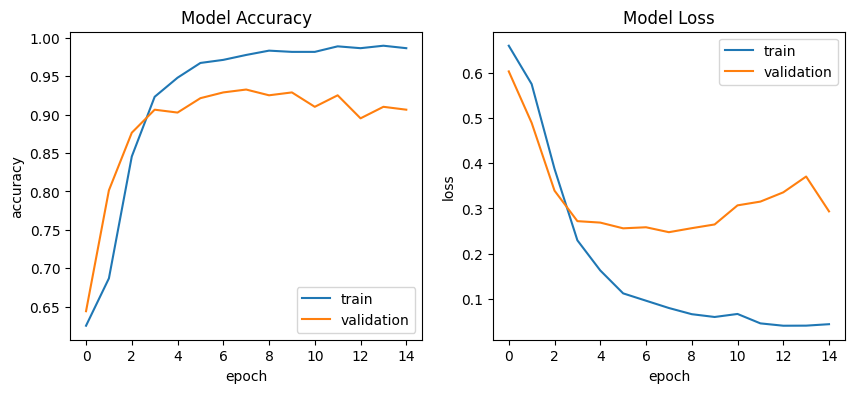

In [87]:
def plot_training_hist(history):
    '''Function to plot history for accuracy and loss'''
    
    fig, ax = plt.subplots(1, 2, figsize=(10,4))
    # first plot
    ax[0].plot(history.history['acc'])
    ax[0].plot(history.history['val_acc'])
    ax[0].set_title('Model Accuracy')
    ax[0].set_xlabel('epoch')
    ax[0].set_ylabel('accuracy')
    ax[0].legend(['train', 'validation'], loc='best')
    # second plot
    ax[1].plot(history.history['loss'])
    ax[1].plot(history.history['val_loss'])
    ax[1].set_title('Model Loss')
    ax[1].set_xlabel('epoch')
    ax[1].set_ylabel('loss')
    ax[1].legend(['train', 'validation'], loc='best')
    
plot_training_hist(history)


9/9 [==============================] - 1s 13ms/step


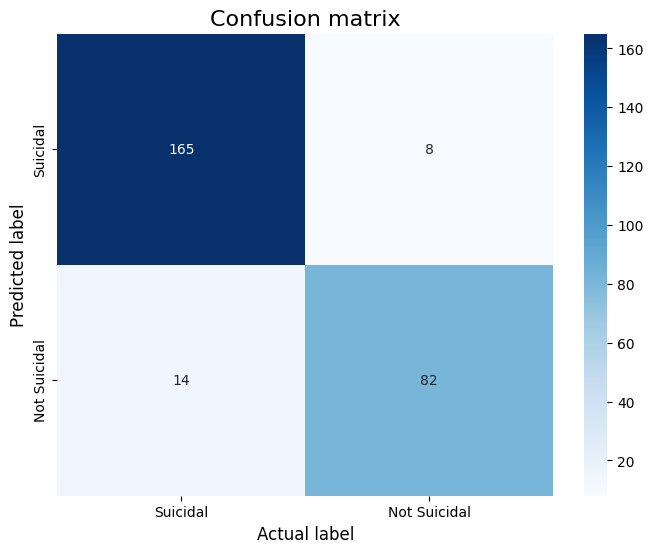

In [88]:
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model, X_test, y_test):
    '''Function to plot confusion matrix for the passed model and the data'''
    
    sentiment_classes = ['Suicidal', 'Not Suicidal',]
    # use model to do the prediction
    y_pred = model.predict(X_test).squeeze()

    # compute confusion matrix
    cm = confusion_matrix(y_test,np.round(y_pred),)
    # plot confusion matrix
    plt.figure(figsize=(8,6))
    sns.heatmap(cm, cmap=plt.cm.Blues, annot=True, fmt='d', 
                xticklabels=sentiment_classes,
                yticklabels=sentiment_classes)
    plt.title('Confusion matrix', fontsize=16)
    plt.xlabel('Actual label', fontsize=12)
    plt.ylabel('Predicted label', fontsize=12)
X_test=test_set.map(lambda x,y: x)
y_test=test_set.map(lambda x,y: y)
y_test=np.concatenate(list(y_test.as_numpy_iterator()))
plot_confusion_matrix(model, X_test, y_test)

## <a name="p8">Saving and using the Model</a>

In [91]:
# Save the model architecture & the weights
model.save('model.tf')

Best model saved


In [ ]:
# Load model
model = tf.keras.models.load_model('model.tf')

In [108]:
def predict_tweets(tweets):
    res= {0:"Not Suicide post", 1:"Potential Suicide post "}
    results=[]
    
    for output in np.round(model.predict(tweets)):
        results.append(res[output[0]])
    return dict(zip(tweets,results))
some_tweets =[ 'I would love to die',
             'I enjoy swimming ',
             'Life is amazing']
predict_tweets(some_tweets)

1/1 [==============================] - 0s 35ms/step


{'I would love to die': 'Potential Suicide post ',
 'I enjoy swimming ': 'Not Suicide post',
 'Life is amazing': 'Not Suicide post'}

## <a name="p9">Conclusion</a>

I have achieved a 91% accuracy in predicting potential suicide posts with the current model. To further enhance its performance, I can consider augmenting the training data and making architectural adjustments. Additionally, the model's accuracy may benefit from unsupervised pretraining or the integration of pretrained layers from the community.

In the next steps, I will work on integrating this model into an approach that autonomously identifies potentially suicidal individuals' usernames. This will allow me to share this information and encourage others to extend their help and support during this challenging phase of their lives.